In [60]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import os
from dotenv import load_dotenv
import pyfredapi as pf
import requests
import re
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress specific FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [61]:
load_dotenv()
# get my FRED_API_KEY from my local environment
api_key = os.environ['FRED_API_KEY']

In [100]:
start = '1990-01-01'

In [113]:
"""
Business confidence index (BCI) - https://data.oecd.org/leadind/business-confidence-index-bci.htm - 1974
Consumer confidence index (CCI) - https://data.oecd.org/leadind/consumer-confidence-index-cci.htm#indicator-chart - 1974
Composite leading indicator (CLI) - https://data.oecd.org/leadind/composite-leading-indicator-cli.htm#indicator-chart - 1974
"""

'\nBusiness confidence index (BCI) - https://data.oecd.org/leadind/business-confidence-index-bci.htm - 1974\nConsumer confidence index (CCI) - https://data.oecd.org/leadind/consumer-confidence-index-cci.htm#indicator-chart - 1974\nComposite leading indicator (CLI) - https://data.oecd.org/leadind/composite-leading-indicator-cli.htm#indicator-chart - 1974\n'

In [104]:
index_csvs = ['INDEX_DATA/BCI.csv', 'INDEX_DATA/CCI.csv', 'INDEX_DATA/CLI.csv']

index_dfs = [pd.read_csv(index_csv) for index_csv in index_csvs]
cleaned_dfs = []
# stack the dataframes
for df in index_dfs:
    indicator = df['INDICATOR'].iloc[0]
    df = df.loc[df['LOCATION'] == 'USA', ['TIME', 'Value']].rename(columns={'Value': 'value_' + indicator, 'TIME': 'date'})
    # set the index to the time column as a datetime object
    df.set_index(pd.to_datetime(df['date']), inplace=True)
    # drop the old time column
    df.drop(columns=['date'], inplace=True)

    # drop all rows with index before string 'start'
    df = df.loc[df.index >= start]

    cleaned_dfs.append(df)

# merge the cleaned_dfs
index_df = pd.concat(cleaned_dfs, axis=1)

In [3]:
data_sources = """
(FEDFUNDS)
Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
Sticky Price Consumer Price Index less Food and Energy (CORESTICKM159SFRBATL)
Sticky Price Consumer Price Index less Food, Energy, and Shelter (CRESTKCPIXSLTRM159SFRBATL)
Producer Price Index by Commodity: All Commodities (PPIACO)
Personal Consumption Expenditures (PCE) 
Total Nonfarm Private Payroll Employment (ADPWNUSNERSA)
Quarterly Financial Report: U.S. Corporations: All Information: Total Cash on Hand and in U.S. Banks  (QFRTCASHINFUSNO) - only to 2009 
Unemployment Rate (UNRATE)
Noncyclical Rate of Unemployment (NROU)
Unemployment Rate - Women (LNS14000002)
Job Openings: Total Nonfarm (JTSJOL) - begins 2000
Layoffs and Discharges: Total Nonfarm (JTSLDL) - since 2000 Gross Domestic Product (GDP)
Real Gross Domestic Product (GDPC1)
Real gross domestic product per capita (A939RX0Q048SBEA)
Gross Domestic Product: Implicit Price Deflator (A191RI1Q225SBEA)
National Accounts: National Accounts Deflators: Gross Domestic Product: GDP Deflator for United States (USAGDPDEFQISMEI)
Advance Retail Sales: Retail Trade and Food Services (RSAFS) - 1992 
University of Michigan: Consumer Sentiment (UMCSENT)
New Privately-Owned Housing Units Started: Total Units (HOUST)
New Privately-Owned Housing Units Started: Single-Family Units (HOUST1F)
Total Business Sales (TOTBUSSMSA) -1992

Nonfinancial Corporate Business; Inventories Including IVA, Market Value Levels (BOGZ1LM105020005Q)
Corporate Profits After Tax -without IVA and CCAdj- (CP)
 National income: Corporate profits before tax -without IVA and CCAdj- (A053RC1Q027SBEA)
Money Market Funds; Total Financial Assets, Level (MMMFFAQ027S)
Stock Market Capitalization to GDP for United States (DDDM01USA156NWDB)
Interest Rates: Long-Term Government Bond Yields: 10-Year: Main -Including Benchmark- for United States (IRLTLT01USM156N)
Nominal Broad U.S. Dollar Index (DTWEXBGS) - 2006
Leading Indicators OECD: Leading indicators: CLI: Amplitude adjusted for OECD - Total (OECDLOLITOAASTSAM)
Trade Balance: Goods and Services, Balance of Payments Basis (BOPGSTB) - 1992
M1 (WM1NS)
Velocity of M1 Money Stock (M1V)
M2 (WM2NS)
"""

In [62]:
# Regular expression pattern to match text within parentheses
pattern = r"\((.*?)\)"

# Find all matches and store them in a list
matches = re.findall(pattern, data_sources)

In [63]:
dataframes = {}

In [88]:
start = '1990-01-01'
# end with the current date
end = pd.Timestamp.today().strftime('%Y-%m-%d')

extra_parameters = {
    "observation_start": start,
    "observation_end": end,
}
for match in matches:
    series_id = match
    try:
        df = pf.get_series(series_id=series_id, **extra_parameters)[['date', 'value']]
        # add the match to the end of the value column name
        df.rename(columns={'value': f'value_{match}'}, inplace=True)
        # turn the date column into a datetime object
        df['date'] = pd.to_datetime(df['date'])

        # set the date column as the index
        df.set_index('date', inplace=True)
        dataframes[series_id] = df

    except:
        print(f"Failed to get {series_id}")
# gdp_df = pf.get_series(series_id="FEDFUNDS", **extra_parameters)
# display(gdp_df)

In [89]:
def align_dataframes(dataframes):
    aligned_dfs = []
    start_date = '1990-01-01'

    for df in dataframes:
        # Ensure the index is a DateTimeIndex
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)

        # Resample to monthly frequency
        # Use 'mean' for downsampling and 'ffill' for upsampling
        resampled_df = df.resample('M').mean().ffill()

        # Align start date to January 1990, filling missing values with NaN
        aligned_df = resampled_df.reindex(pd.date_range(start_date, resampled_df.index.max(), freq='M'), fill_value=np.nan)
        
        aligned_dfs.append(aligned_df)

    return aligned_dfs

In [108]:
dataframes_list = list(dataframes.values()) + [index_df]

display(dataframes_list[-1])

# Align all DataFrames to the same frequency and start date
aligned_dataframes = align_dataframes(dataframes_list)

# Concatenate all DataFrames along the column axis
combined_df = pd.concat(aligned_dataframes, axis=1)

display(combined_df)

,value_BCI,value_CCI,value_CLI
date,,,
1990-01-01,98.82152,100.64830,99.79324
1990-02-01,99.03415,100.63020,99.82359
1990-03-01,99.20221,100.69920,99.82265
1990-04-01,99.25509,100.75180,99.74673
1990-05-01,99.17876,100.62180,99.57410
...,...,...,...
2023-06-01,98.50663,97.54726,99.11828
2023-07-01,98.58130,97.90887,99.24326
2023-08-01,98.72079,97.98888,99.34666


,value_FEDFUNDS,value_CPIAUCSL,value_CORESTICKM159SFRBATL,value_CRESTKCPIXSLTRM159SFRBATL,value_PPIACO,value_PCE,value_ADPWNUSNERSA,value_QFRTCASHINFUSNO,value_UNRATE,value_NROU,...,value_IRLTLT01USM156N,value_DTWEXBGS,value_OECDLOLITOAASTSAM,value_BOPGSTB,value_WM1NS,value_M1V,value_WM2NS,value_BCI,value_CCI,value_CLI
1990-01-31,8.23,127.500,4.920589,4.822856,114.900,3730.7,NaN,NaN,5.4,5.732765,...,8.21,NaN,100.686551,NaN,805.860,7.356,3173.160,98.82152,100.64830,99.79324
1990-02-28,8.24,128.000,4.935526,5.031079,114.400,3728.2,NaN,NaN,5.3,5.732765,...,8.47,NaN,100.691920,NaN,786.300,7.356,3169.175,99.03415,100.63020,99.82359
1990-03-31,8.28,128.600,5.208701,5.303906,114.200,3754.9,NaN,NaN,5.2,5.732765,...,8.59,NaN,100.675582,NaN,793.500,7.356,3189.875,99.20221,100.69920,99.82265
1990-04-30,8.26,128.900,5.294134,5.351800,114.100,3770.0,NaN,NaN,5.4,5.713231,...,8.79,NaN,100.619091,NaN,813.200,7.391,3216.700,99.25509,100.75180,99.74673
1990-05-31,8.18,129.100,5.183754,5.319868,114.600,3775.8,NaN,NaN,5.4,5.713231,...,8.76,NaN,100.510613,NaN,795.150,7.391,3186.150,99.17876,100.62180,99.57410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,5.12,304.348,5.456089,3.265160,253.805,18621.3,128846600.0,NaN,3.5,4.421397,...,3.90,118.584800,NaN,-64718.0,18345.020,1.511,20749.380,98.58130,97.90887,99.24326
2023-08-31,5.33,306.269,5.217343,3.094960,257.675,18689.9,128955000.0,NaN,3.8,4.421397,...,4.17,120.378709,NaN,-58657.0,18232.575,NaN,20718.350,98.72079,97.98888,99.34666
2023-09-30,5.33,307.481,5.008782,2.919115,258.889,18823.4,129091200.0,NaN,3.8,4.421397,...,4.38,122.125230,NaN,-61542.0,18153.050,NaN,20703.425,98.79745,97.82825,99.42249
2023-10-31,5.33,307.619,4.931956,2.979587,255.463,18864.7,129222250.0,NaN,3.9,4.418317,...,4.80,123.904114,NaN,NaN,18047.300,NaN,20674.720,98.71177,97.52642,99.47179


                                 value_FEDFUNDS  value_CPIAUCSL  \
value_FEDFUNDS                         1.000000       -0.626860   
value_CPIAUCSL                        -0.626860        1.000000   
value_CORESTICKM159SFRBATL             0.564872       -0.146998   
value_CRESTKCPIXSLTRM159SFRBATL        0.528708       -0.354919   
value_PPIACO                          -0.591412        0.969235   
value_PCE                             -0.592146        0.995732   
value_ADPWNUSNERSA                     0.698382        0.825040   
value_QFRTCASHINFUSNO                  0.156623        0.781307   
value_UNRATE                          -0.419009       -0.112245   
value_NROU                             0.694027       -0.983833   
value_LNS14000002                     -0.388290       -0.124366   
value_JTSJOL                           0.120383        0.827174   
value_JTSLDL                          -0.031552       -0.096984   
value_GDP                             -0.619015        0.99452

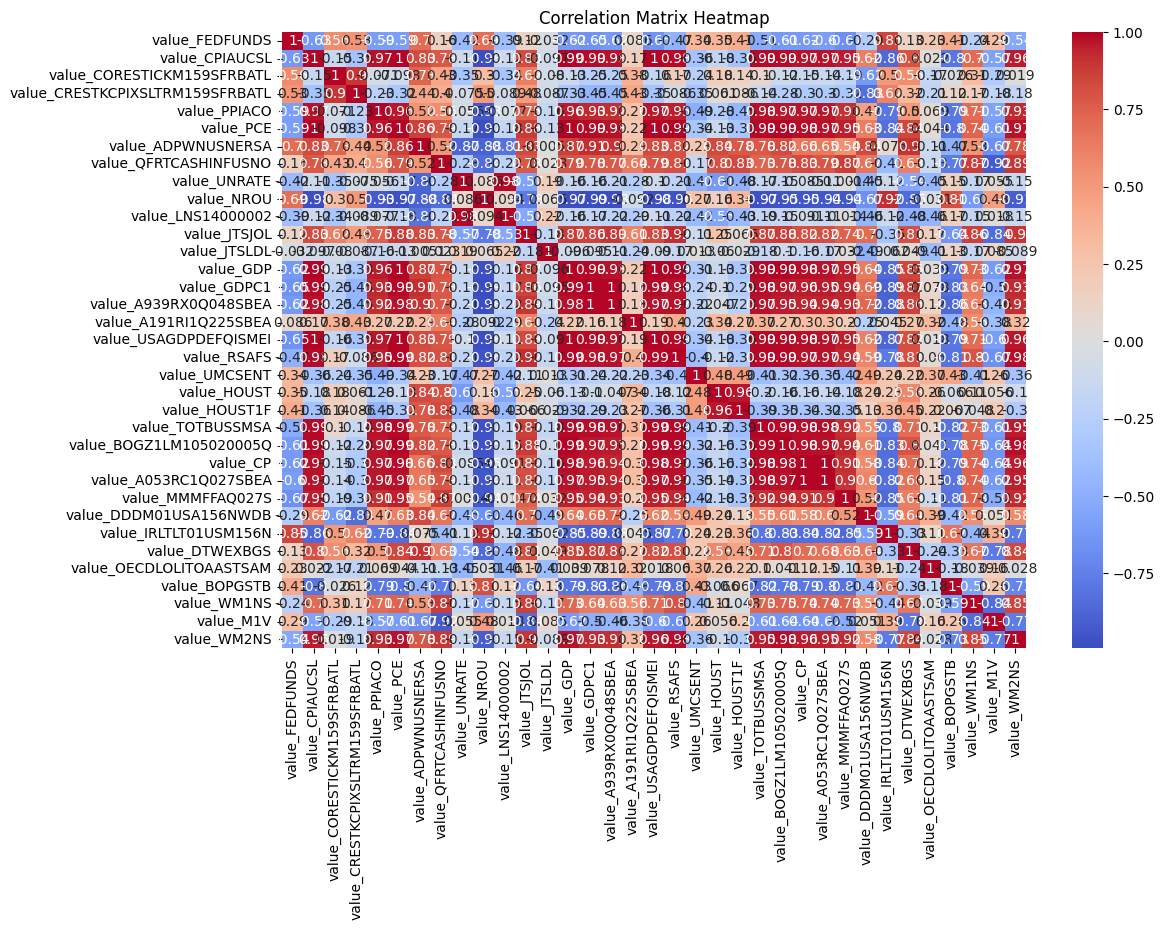

In [9]:
# Assuming 'combined_df' is your combined DataFrame
corr_matrix = combined_df.corr()

# Display the correlation matrix
print(corr_matrix)

# Plotting a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [77]:
features = combined_df.drop('value_FEDFUNDS', axis=1)
label = combined_df['value_FEDFUNDS']

display(label)

# Filling missing values with the mean (change this based on your data's context)
features_filled = features.fillna(features.mean())


1990-01-31    8.23
1990-02-28    8.24
1990-03-31    8.28
1990-04-30    8.26
1990-05-31    8.18
              ... 
2023-07-31    5.12
2023-08-31    5.33
2023-09-30    5.33
2023-10-31    5.33
2023-11-30    5.33
Freq: M, Name: value_FEDFUNDS, Length: 407, dtype: float64

In [56]:
# # plot the label
# plt.plot(label.index, label)
# plt.title('FEDFUNDS')

In [83]:
split_date = '2015-01-01'
train_features = features[:split_date]
test_features = features[split_date:]
train_label = label[:split_date]

test_label = label[split_date:]

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

# Apply imputation to the training and testing sets
train_features_imputed = imputer.fit_transform(train_features)
test_features_imputed = imputer.transform(test_features)

# Then, standardize and apply PCA as before
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_imputed)
test_features_scaled = scaler.transform(test_features_imputed)

pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_features_scaled)
test_pca = pca.transform(test_features_scaled)

# Create Ridge regression model
ridge_model = linear_model.Ridge(alpha=1.0, solver='svd')

# Fit the model using transformed features
ridge_model.fit(train_pca, train_label)

# Make predictions using transformed test features
predicted_rates = ridge_model.predict(test_pca)
predicted_rates = np.clip(predicted_rates, 0, None)

# Calculate MSE
mse = mean_squared_error(test_label, predicted_rates)

# Print the MSE
print("Mean Squared Error:", mse)

Mean Squared Error: 4.748801679868019


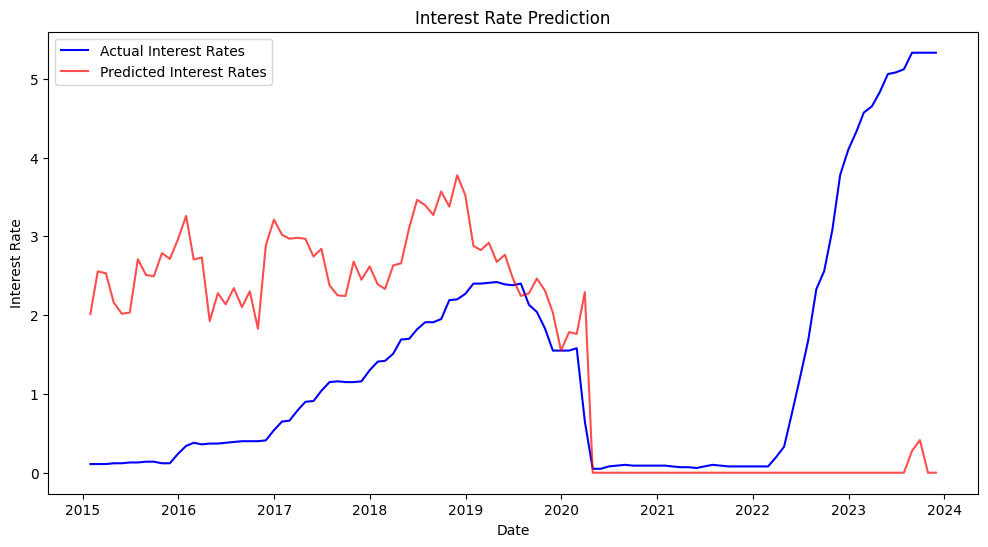

In [84]:
# Assuming the index of your test set represents the dates
test_dates = test_label.index

plt.figure(figsize=(12, 6))
plt.plot(test_dates, test_label, label='Actual Interest Rates', color='blue')
plt.plot(test_dates, predicted_rates, label='Predicted Interest Rates', color='red', alpha=0.7)
plt.title('Interest Rate Prediction')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()

Mean Squared Error with XGBoost: 4.460337280503605


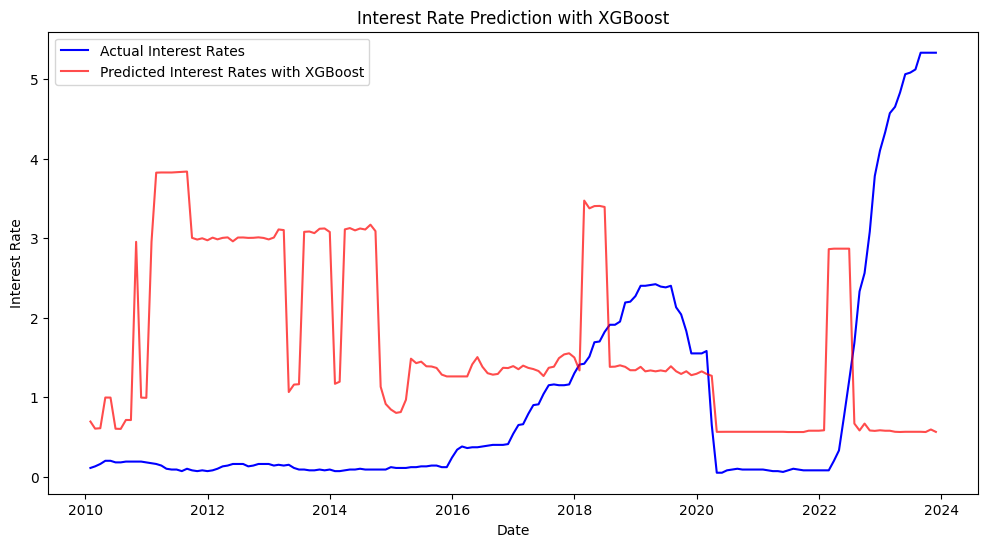

In [88]:
import xgboost as xgb
split_date = '2010-01-01'
train_features = features[:split_date]
test_features = features[split_date:]
train_label = label[:split_date]
test_label = label[split_date:]

imputer = SimpleImputer(strategy='mean')
train_features_imputed = imputer.fit_transform(train_features)
test_features_imputed = imputer.transform(test_features)

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_imputed)
test_features_scaled = scaler.transform(test_features_imputed)

pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_features_scaled)
test_pca = pca.transform(test_features_scaled)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(train_pca, train_label)

xgb_predictions = xgb_model.predict(test_pca)
# xgb_predictions = np.clip(xgb_predictions, 0, None)

mse_xgb = mean_squared_error(test_label, xgb_predictions)
print("Mean Squared Error with XGBoost:", mse_xgb)

plt.figure(figsize=(12, 6))
plt.plot(test_label.index, test_label, label='Actual Interest Rates', color='blue')
plt.plot(test_label.index, xgb_predictions, label='Predicted Interest Rates with XGBoost', color='red', alpha=0.7)
plt.title('Interest Rate Prediction with XGBoost')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()

In [103]:
split_date = '2015-01-01'
train_features = features[:split_date]
print(train_features.shape)
test_features = features[split_date:]
train_label = label[:split_date]
test_label = label[split_date:]
imputer = SimpleImputer(strategy='mean')
train_features_imputed = imputer.fit_transform(train_features)
test_features_imputed = imputer.transform(test_features)

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_imputed)
test_features_scaled = scaler.transform(test_features_imputed)


xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(train_features_scaled, train_label)

xgb_predictions = xgb_model.predict(test_features_scaled)
# xgb_predictions = np.clip(xgb_predictions, 0, None)

mse_xgb = mean_squared_error(test_label, xgb_predictions)
print("Mean Squared Error with XGBoost:", mse_xgb)


(300, 34)
Mean Squared Error with XGBoost: 2.7711334169876793


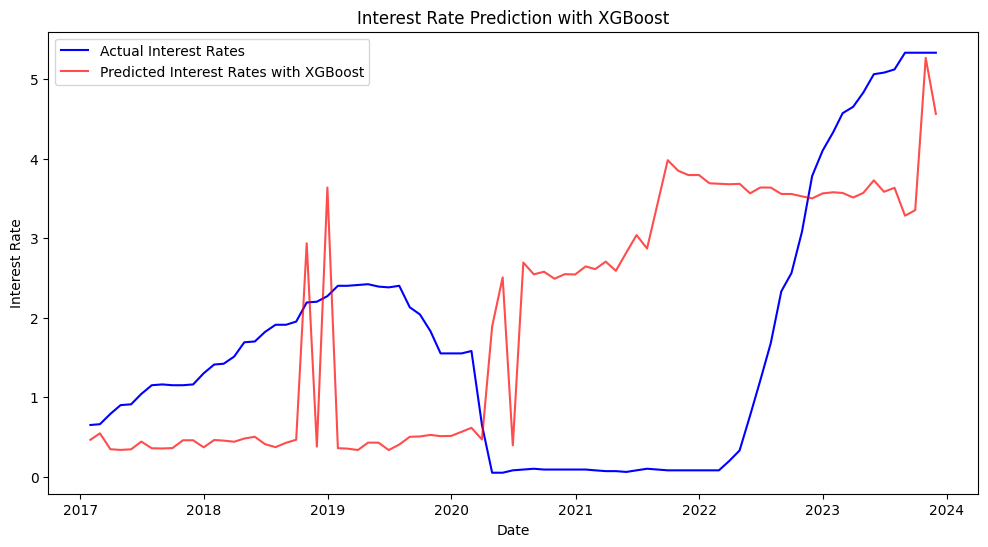

In [100]:
plt.figure(figsize=(12, 6))
plt.plot(test_label.index, test_label, label='Actual Interest Rates', color='blue')
plt.plot(test_label.index, xgb_predictions, label='Predicted Interest Rates with XGBoost', color='red', alpha=0.7)
plt.title('Interest Rate Prediction with XGBoost')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()

In [44]:
import xgboost as xgb
label_binary = label.diff().dropna()
split_date = int(len(label_binary) * 0.8)
label_binary = np.where(label_binary > 0, 1, 0)

features_adjusted = features.iloc[1:]

train_features = features_adjusted[:split_date]
test_features = features_adjusted[split_date:]
train_label = label_binary[:split_date]
test_label = label_binary[split_date:]

# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the classifier
xgb_classifier.fit(train_features, train_label)


# Predictions
xgb_predictions = xgb_classifier.predict(test_features)

# Evaluation
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(test_label, xgb_predictions)
print("Accuracy:", accuracy)
print(classification_report(test_label, xgb_predictions))


Accuracy: 0.6097560975609756
              precision    recall  f1-score   support

           0       0.75      0.09      0.16        34
           1       0.60      0.98      0.75        48

    accuracy                           0.61        82
   macro avg       0.68      0.53      0.45        82
weighted avg       0.66      0.61      0.50        82



In [57]:
# Create a binary label for increase (1) or decrease (0) in interest rates
label_binary = label.diff().dropna()
label_binary = np.where(label_binary > 0, 1, 0)

# Shift the binary label forward by one period
for i in range(1, 13):
    label_shifted = np.roll(label_binary, -i)

    features_aligned = features.iloc[1:-1]
    label_aligned = label_shifted[:-1]


    split_index = int(len(label_aligned) * 0.8)

    train_features = features_aligned[:split_index]
    test_features = features_aligned[split_index:]
    train_label = label_aligned[:split_index]
    test_label = label_aligned[split_index:]


    xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.1, max_depth=5, random_state=42)
    xgb_classifier.fit(train_features, train_label)

    xgb_predictions = xgb_classifier.predict(test_features)
    accuracy = accuracy_score(test_label, xgb_predictions)

    print("Accuracy:", accuracy)
    # print(classification_report(test_label, xgb_predictions))


Accuracy: 0.5679012345679012
Accuracy: 0.38271604938271603
Accuracy: 0.5555555555555556
Accuracy: 0.5925925925925926
Accuracy: 0.5679012345679012
Accuracy: 0.5432098765432098
Accuracy: 0.5555555555555556
Accuracy: 0.5679012345679012
Accuracy: 0.37037037037037035
Accuracy: 0.4691358024691358
Accuracy: 0.43209876543209874
Accuracy: 0.48148148148148145


In [ ]:
# # get tags
# request_url = f'https://api.stlouisfed.org/fred/tags'

# params = {
#     'api_key': api_key,
#     'file_type': 'json',
#     'limit': 1000,
#     'order_by': 'popularity',
#     # 'offset': 0,
# }
# tags_response = requests.get(request_url, params=params)
# # response_json = tags_response.json()
# # tags_df = pd.DataFrame(response_json['tags'])
# # display(tags_df)
# # print(tags_df['name'].to_list())

In [106]:
# response_json = tags_response.json()
# tags_df = pd.DataFrame(response_json['tags'])
# display(tags_df)

In [107]:
# request_url = f'https://api.stlouisfed.org/fred/releases'

# params = {
#     'api_key': api_key,
#     'file_type': 'json',
#     'limit': 1000,
#     # 'offset': 10,
# }
# response = requests.get(request_url, params=params)
# # # print the 'name' for each Release
# # for release in response.json()['releases']:
# #     print(release['name'])